## CLIP ViT-B/32 Representation Analysis

In [71]:
import torch
from torchvision import datasets
from torch.utils.data import Dataset, DataLoader, Subset, ConcatDataset
import clip
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
from sklearn.manifold import TSNE
import random
import numpy as np

In [ ]:
device = "cuda" if torch.cuda.is_available() else "mps" if torch.mps.is_available() else "cpu"
print("Device:", device)
model, preprocess = clip.load("ViT-B/32", device=device)

Device: cuda


### Preparing CIFAR-10 + PACS (sketch, painting, cartoon) mixed dataset with domain + class labels

In [73]:
transform = preprocess

cifar_dataset = datasets.CIFAR10(
    root="./data",
    train=False,
    download=True,
    transform=preprocess
)

class_indices = {i: [] for i in range(10)}
for idx, (_, label) in enumerate(cifar_dataset):
    if len(class_indices[label]) < 50:
        class_indices[label].append(idx)

selected_indices = [i for indices in class_indices.values() for i in indices]
cifar_subset = Subset(cifar_dataset, selected_indices)


pacs_root = "data/pacs_data/pacs_data"
domains = ["cartoon", "art_painting", "sketch"]

pacs_datasets = {}
pacs_subsets = []

for domain in domains:
    domain_path = f"{pacs_root}/{domain}"
    dataset = datasets.ImageFolder(root=domain_path, transform=preprocess)
    pacs_datasets[domain] = dataset

    n_samples = 350
    indices = random.sample(range(len(dataset)), n_samples)
    pacs_subsets.append(Subset(dataset, indices))

print("CIFAR-10 subset size:", len(cifar_subset))
print("PACS Subset size:", sum(len(s) for s in pacs_subsets))

CIFAR-10 subset size: 500
PACS Subset size: 1050


In [74]:
cifar_classes = [
    "airplane", "automobile", "bird", "cat", "deer",
    "dog", "frog", "horse", "ship", "truck"
]

class LabeledSubset(Dataset):
    def __init__(self, subset, labels, source="cifar", domain=None):
        self.subset = subset
        self.labels = labels
        self.source = source
        self.domain = domain

    def __getitem__(self, idx):
        img, label = self.subset[idx] 
        class_name = self.labels[label]

        if self.source == "cifar":
            formatted_label = f"{class_name} picture"
        else:  # PACS
            if self.domain == "art_painting":
                formatted_label = f"{class_name} painting"
            elif self.domain == "sketch":
                formatted_label = f"{class_name} sketch"
            elif self.domain == "cartoon":
                formatted_label = f"{class_name} cartoon"
            else:
                formatted_label = class_name

        return img, formatted_label

    def __len__(self):
        return len(self.subset)
    
# CIFAR-10
cifar_labeled = LabeledSubset(
    cifar_subset,
    labels=cifar_classes,
    source="cifar"
)

# PACS
pacs_labeled_subsets = []
for domain, subset in zip(domains, pacs_subsets):
    labels = pacs_datasets[domain].classes
    labeled = LabeledSubset(subset, labels=labels, source="pacs", domain=domain)
    pacs_labeled_subsets.append(labeled)

# Merge datasets
final_dataset = ConcatDataset([cifar_labeled] + pacs_labeled_subsets)

loader = DataLoader(
    final_dataset,
    batch_size=128,
    shuffle=False,
    num_workers=0
)

In [75]:
# --- Saving dataset for Task 1 use ---

all_images = []
all_labels = []

for i in range(len(final_dataset)):
    img, label = final_dataset[i]
    all_images.append(img)
    all_labels.append(label)

dataset_dict = {
    "images": torch.stack(all_images),
    "labels": all_labels
}

torch.save(dataset_dict, "data/representation_set.pt")
print("Saved dataset")

# --- Loading ---
# dataset_dict = torch.load("data/representation_set.pt")
# print(dataset_dict["labels"][:5])


Saved dataset


### CLIP Embeddings of the mixed dataset

In [76]:
all_image_features = []
all_labels = []

with torch.no_grad():
    for images, labels in loader:
        images = images.to(device, non_blocking=True)

        image_features = model.encode_image(images)
        image_features /= image_features.norm(dim=-1, keepdim=True)
        all_image_features.append(image_features.cpu())
        all_labels.extend(labels)

all_image_features = torch.cat(all_image_features, dim=0)


### t-SNE Dimensionality Reduction and Plotting

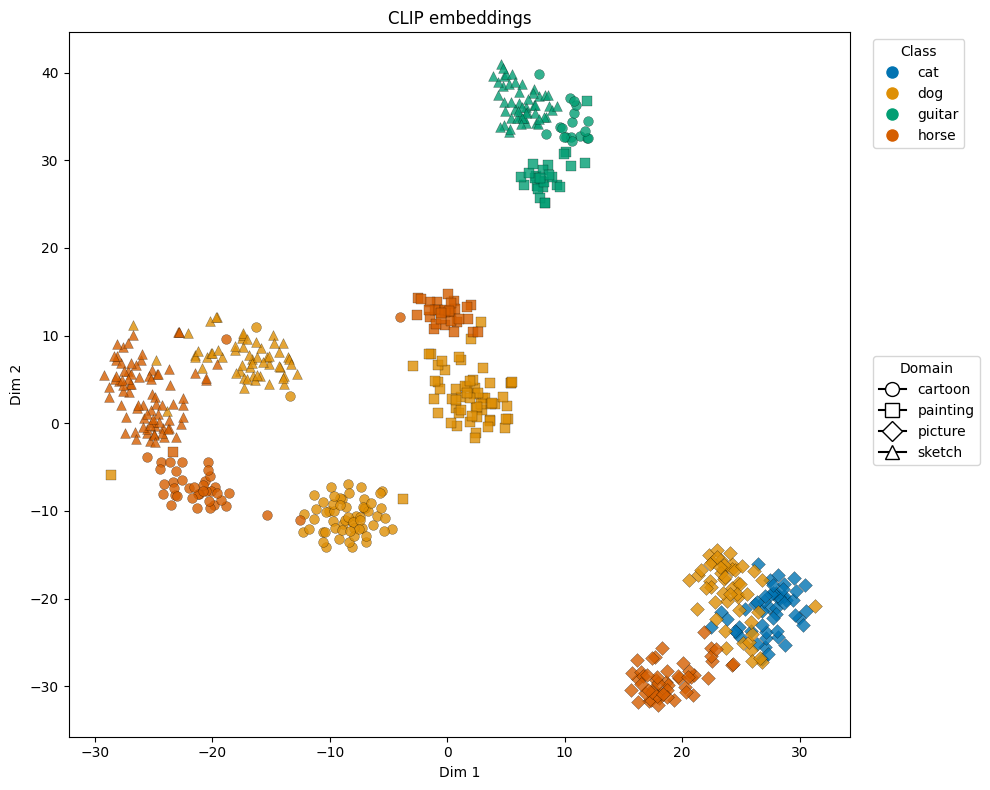

In [79]:
plot_classes = ["dog", "horse", "cat", "guitar"]

features = all_image_features.cpu().numpy()
labels = np.array(all_labels)
classes = np.array([s.rsplit(" ", 1)[0] for s in labels])
domains = np.array([s.rsplit(" ", 1)[1] for s in labels])

# Build mask to keep only chosen classes (matches start of label)
mask = np.isin(classes, plot_classes)

X = features[mask]
classes_plot = classes[mask]
domains_plot = domains[mask]

tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=42)
X2 = tsne.fit_transform(X)

# Color map for classes
unique_classes = np.unique(classes_plot)
palette = sns.color_palette("colorblind", n_colors=len(unique_classes))
class2color = {c: palette[i % len(palette)] for i, c in enumerate(unique_classes)}

# Marker map for domains
unique_domains = np.unique(domains_plot)
markers = ["o", "s", "D", "^"]
domain2marker = {d: markers[i % len(markers)] for i, d in enumerate(unique_domains)}

plt.figure(figsize=(10, 8))
ax = plt.gca()
for cls in unique_classes:
    for dom in unique_domains:
        idx = (classes_plot == cls) & (domains_plot == dom)
        if not np.any(idx):
            continue
        ax.scatter(
            X2[idx, 0], X2[idx, 1],
            c=[class2color[cls]],
            marker=domain2marker[dom],
            s=50,
            alpha=0.8,
            edgecolor="k",
            linewidth=0.2,
            label=f"{cls} — {dom}"
        )
ax.set_title("CLIP embeddings")
ax.set_xlabel("Dim 1")
ax.set_ylabel("Dim 2")
class_handles = [
    Line2D([0], [0], marker='o', color='w', label=c,
           markerfacecolor=class2color[c], markersize=10)
    for c in unique_classes
]
domain_handles = [
    Line2D([0], [0], marker=domain2marker[d], color='k', label=d,
           markerfacecolor='w', markersize=10)
    for d in unique_domains
]
legend1 = ax.legend(handles=class_handles, title="Class", bbox_to_anchor=(1.02, 1), loc='upper left')
ax.add_artist(legend1)
ax.legend(handles=domain_handles, title="Domain", bbox_to_anchor=(1.02, 0.55), loc='upper left')
plt.tight_layout()
plt.show()